# Comments Network Builder

## Description
Build the semantic network from clean Reddit posts' comments for network anaylsis

## Setup

### Libraries (Pyhton)

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
from pathlib import Path
import sys

### Directories

In [2]:
try:
    BASE_DIR = Path(__file__).resolve().parent
except NameError:
    BASE_DIR = Path().resolve()

SRC_DIR = BASE_DIR / 'src'
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

DATA_DIR = BASE_DIR / 'data'
DATA_DIR.mkdir(exist_ok=True)
POSTS_DIR = DATA_DIR / 'posts'
POSTS_ALL_DIR = POSTS_DIR / 'all'
POSTS_FILTERED_DIR = POSTS_DIR / 'filtered'
POSTS_FILTERED_CLEAN_DIR = POSTS_FILTERED_DIR / 'clean'
COMMENTS_DIR = DATA_DIR / 'comments'
COMMENTS_CLEAN_DIR = COMMENTS_DIR / 'clean'
RESULTS_DIR = BASE_DIR / 'results'
RESULTS_GRAPHS_DIR = RESULTS_DIR / 'graphs'

### Libraries (Custom)

In [3]:
import builder as bn

## Import Data

In [4]:
filename_posts = POSTS_FILTERED_CLEAN_DIR / 'all_posts_clean.json'
filename_comments = COMMENTS_CLEAN_DIR / 'all_comments_clean.json'
posts = pd.read_json(filename_posts)
comments = pd.read_json(filename_comments)

## Build Bipartite Network

In [5]:
# --- Prep posts ---
df_posts = posts.copy()
df_posts['document_id'] = df_posts['id']
df_posts['document_type'] = 'post'

# --- Prep comments ---
df_comments = comments.copy()
df_comments['document_id'] = df_comments['comment_id']
df_comments['document_type'] = 'comment'

# --- Ensure the same columns exist in both ---
common_cols = list(set(df_posts.columns).intersection(set(df_comments.columns)))
df_merged = pd.concat([df_posts[common_cols], df_comments[common_cols]], ignore_index=True)

In [6]:
network = bn.BuildNetwork(df_merged, column='filtered_pos')
network.build(tfidf=True)

In [7]:
# Create a document_id to metadata mapping
doc_metadata = df_merged.set_index('document_id').to_dict(orient='index')

In [8]:
G_bip_merged = bn.to_networkx_bipartite(network, use='Pwd')
print(f"Bipartite graph has {G_bip_merged.number_of_nodes()} nodes and {G_bip_merged.number_of_edges()} edges.")

Bipartite graph has 24588 nodes and 403574 edges.


In [9]:
# Assign metadata to document nodes
for node in G_bip_merged.nodes():
    if node in doc_metadata:
        for key, val in doc_metadata[node].items():
            G_bip_merged.nodes[node][key] = val

### Analyze Degree Distribution

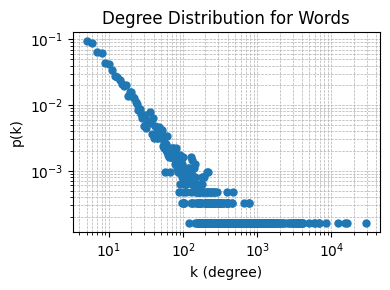

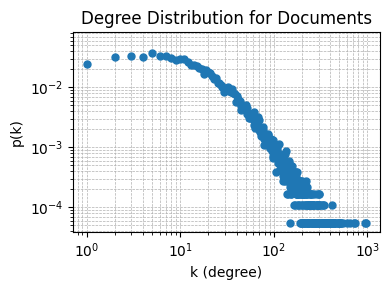

In [10]:
network.plot_degree_distribution(type='words')
network.plot_degree_distribution(type='documents')

--- Power-Law Analysis (words) ---
Alpha (scaling exponent): 2.0085
xmin (cutoff): 112.0


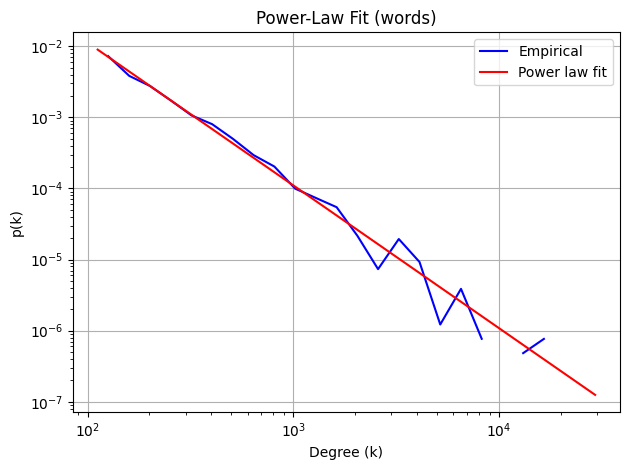

--- Power-Law Analysis (documents) ---
Alpha (scaling exponent): 3.9045
xmin (cutoff): 183.0


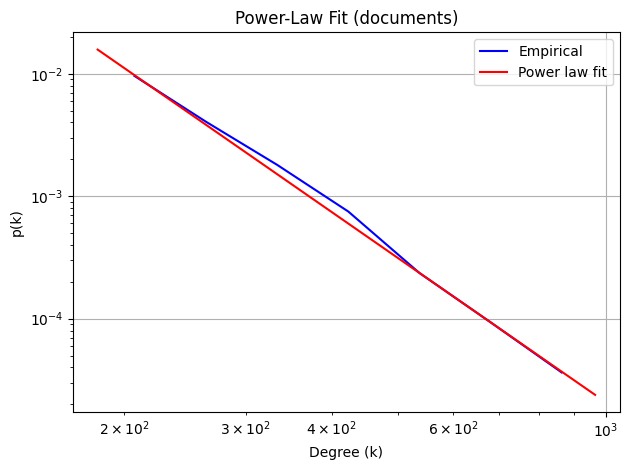

In [11]:
network.analyze_degree_distribution_powerlaw(type='words')
network.analyze_degree_distribution_powerlaw(type='documents')

## Build Projected Network
Project the bipartite network onto words.

#### Analyze Weights
Use the weights distribution to set a threshold for sparsity.

In [12]:
Pww = network.Pww
triu_indices = np.triu_indices_from(Pww, k=1) # Get upper triangle (Pww is symmetric)
weights = Pww[triu_indices]
weights = weights[weights > 0]  # Remove zeros

print("Edge weight distribution (non-zero weights only):")
print(f"Total edges: {len(weights):,}")
print(f"Min weight: {weights.min():.6f}")
print(f"Max weight: {weights.max():.6f}")
print("Percentiles:")
for p in [50, 75, 80, 90, 95, 99, 99.5, 99.9]:
    val = np.percentile(weights, p)
    print(f"{p:>5.1f}th percentile: {val:.6f}")

Edge weight distribution (non-zero weights only):
Total edges: 2,628,289
Min weight: 0.000000
Max weight: 0.289882
Percentiles:
 50.0th percentile: 0.000005
 75.0th percentile: 0.000015
 80.0th percentile: 0.000019
 90.0th percentile: 0.000041
 95.0th percentile: 0.000081
 99.0th percentile: 0.000362
 99.5th percentile: 0.000671
 99.9th percentile: 0.002591


#### Build Network

In [13]:
sparsity_threshold = np.percentile(weights, 95.0)
G_merged_word = bn.to_networkx_word_projection(network, use='Pww', threshold=sparsity_threshold)
print(f"Word-projected graph has {G_merged_word.number_of_nodes()} nodes and {G_merged_word.number_of_edges()} edges.")

Word-projected graph has 6247 nodes and 131415 edges.


In [14]:
# Basic stats
print(f"Average degree: {np.mean([d for _, d in G_merged_word.degree()]):.2f}")
print(f"Connected components: {nx.number_connected_components(G_merged_word)}")

# Largest component
largest_cc = max(nx.connected_components(G_merged_word), key=len)
print(f"Largest connected component size: {len(largest_cc)}")

Average degree: 42.07
Connected components: 404
Largest connected component size: 5843


## Save to .gexf

In [15]:
filename_b = RESULTS_GRAPHS_DIR / 'g_bip.gexf'
nx.write_gexf(G_bip_merged, filename_b)

In [16]:
filename_w = RESULTS_GRAPHS_DIR / 'g_proj.gexf'
nx.write_gexf(G_merged_word, filename_w)